# Quantize the Ultralytics YOLOv5 model and check accuracy using the OpenVINO NNCF API

This tutorial demonstrates step-by-step how to perform model quantization using the OpenVINO [Neural Network Compression Framework (NNCF)](https://docs.openvino.ai/2022.1/docs_nncf_introduction.html), compare model accuracy between the FP32 precision and quantized INT8 precision models and run a demo of model inference based on sample code from [Ultralytics Yolov5](https://github.com/ultralytics/yolov5) with the OpenVINO backend.

In [1]:
from pathlib import Path
import os
from IPython.display import Markdown, display

In [2]:
if not Path("./yolov5/").exists():
    command_download = f'{"git clone https://github.com/ultralytics/yolov5.git -b v7.0"}'
    command_download = " ".join(command_download.split())
    print("Download Ultralytics Yolov5 project source:")
    display(Markdown(f"`{command_download}`"))
    download_res = %sx $command_download
else:
    print("Ultralytics Yolov5 repo already exists.")
# %cd ./yolov5

Ultralytics Yolov5 repo already exists.


In [3]:
IMAGE_SIZE = 640
MODEL_NAME = "yolov5m"
MODEL_DIR = "model"

### Conversion of the YOLOv5 model to OpenVINO

YoloV5 `export.py` scripts support multiple model formats for conversion. OpenVINO is also represented among supported formats. We need to specify `--include openvino` parameter for exporting. As the result, directory with name `yolov5m_openvino_model` will be created with following content:
* `yolov5m.yaml` - meta information for usage model with inference demo.
* `yolov5.xml`, `yolov5.bin` - OpenVINO Intermediate Representation (IR) model generated by Model Optimizer.

In [4]:
%cd yolov5

/home/ease/repos/my_openvino_notebooks/notebooks/yolov5v7/yolov5


In [5]:
print("Convert PyTorch model to OpenVINO Model:")
!python export.py --weights {MODEL_DIR}/{MODEL_NAME}.pt --imgsz {IMAGE_SIZE} --batch-size 1 --include ONNX

Convert PyTorch model to OpenVINO Model:
export: data=data/coco128.yaml, weights=['model/yolov5m.pt'], imgsz=[640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['ONNX']
YOLOv5 🚀 v7.0-0-g915bbf2 Python-3.8.13 torch-1.8.1+cpu CPU

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients

PyTorch: starting from model/yolov5m.pt with output shape (1, 25200, 85) (40.8 MB)

ONNX: starting export with onnx 1.11.0...
ONNX: export success ✅ 2.4s, saved as model/yolov5m.onnx (81.2 MB)

Export complete (3.4s)
Results saved to /home/ease/repos/my_openvino_notebooks/notebooks/yolov5v7/yolov5/model
Detect:          python detect.py --weights model/yolov5m.onnx 
Validate:        python val.py --weights model/yolov5m.onnx 
PyTorch Hub:     model = torch.hub.

In [6]:
from openvino.tools import mo
from openvino.runtime import serialize

In [7]:
model_path = Path(MODEL_DIR) / Path(MODEL_NAME)
onnx = f"{model_path.with_suffix('.onnx')}"

In [8]:
output_path = Path(MODEL_DIR) / Path(MODEL_NAME + "_fp32")
out = f"{output_path.with_suffix('.xml')}"

print(f"Export ONNX to OpenVINO FP32 IR to: {output_path}")
model = mo.convert_model(onnx)
# serialize model for saving IR
serialize(model, out)

Export ONNX to OpenVINO FP32 IR to: model/yolov5m_fp32


In [9]:
output_path = Path(MODEL_DIR) / Path(MODEL_NAME + "_fp16")
out = f"{output_path.with_suffix('.xml')}"

print(f"Export ONNX to OpenVINO FP16 IR to: {output_path}")
model = mo.convert_model(onnx, data_type="FP16", compress_to_fp16=True)
# serialize model for saving IR
serialize(model, out)

[ WARNING ]  Use of deprecated cli option --data_type detected. Option use in the following releases will be fatal. 


Export ONNX to OpenVINO FP16 IR to: model/yolov5m_fp16


### Change COCO dataset path

In [10]:
!sed -i 's#../datasets/coco#../coco#g' ./data/coco.yaml
!cat ./data/coco.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# COCO 2017 dataset http://cocodataset.org by Microsoft
# Example usage: python train.py --data coco.yaml
# parent
# ├── yolov5
# └── datasets
#     └── coco  ← downloads here (20.1 GB)


# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ../coco  # dataset root dir
train: train2017.txt  # train images (relative to 'path') 118287 images
val: val2017.txt  # val images (relative to 'path') 5000 images
test: test-dev2017.txt  # 20288 of 40670 images, submit to https://competitions.codalab.org/competitions/20794

# Classes
names:
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: train
  7: truck
  8: boat
  9: traffic light
  10: fire hydrant
  11: stop sign
  12: parking meter
  13: bench
  14: bird
  15: cat
  16: dog
  17: horse
  18: sheep
  19: cow
  20: elephant
  21: bear
  22: zebra
  23: giraffe
  24: backpack
  25: umbrella
  26: handb

In [11]:
!sed -i 's#../datasets/coco128 #../coco128#g' ./data/coco128.yaml
!cat ./data/coco128.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# COCO128 dataset https://www.kaggle.com/ultralytics/coco128 (first 128 images from COCO train2017) by Ultralytics
# Example usage: python train.py --data coco128.yaml
# parent
# ├── yolov5
# └── datasets
#     └── coco128  ← downloads here (7 MB)


# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ../coco128 # dataset root dir
train: images/train2017  # train images (relative to 'path') 128 images
val: images/train2017  # val images (relative to 'path') 128 images
test:  # test images (optional)

# Classes
names:
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: train
  7: truck
  8: boat
  9: traffic light
  10: fire hydrant
  11: stop sign
  12: parking meter
  13: bench
  14: bird
  15: cat
  16: dog
  17: horse
  18: sheep
  19: cow
  20: elephant
  21: bear
  22: zebra
  23: giraffe
  24: backpack
  25: umbrella
  26: handbag
  27: ti

## Verify Model Inference

In [12]:
from collections import namedtuple
from typing import List, Tuple, Dict

import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
from openvino.runtime import Model, Core

from utils.dataloaders import letterbox, create_dataloader
from utils.plots import save_one_box
from utils.general import check_dataset, non_max_suppression, scale_boxes, xywh2xyxy, check_yaml, increment_path, colorstr
from utils.metrics import ap_per_class
from utils.plots import Annotator
from val import process_batch

core = Core()
print(core.available_devices)

['CPU', 'GPU']


In [13]:
def preprocess_image(img0: np.ndarray):
    """
    Preprocess image according to YOLOv7 input requirements. 
    Takes image in np.array format, resizes it to specific size using letterbox resize, converts color space from BGR (default in OpenCV) to RGB and changes data layout from HWC to CHW.
    
    Parameters:
      img0 (np.ndarray): image for preprocessing
    Returns:
      img (np.ndarray): image after preprocessing
      img0 (np.ndarray): original image
    """
    # resize
    img = letterbox(img0, auto=False)[0]
    
    # Convert
    img = img.transpose(2, 0, 1)  # BGR to RGB
    img = np.ascontiguousarray(img)
    return img, img0


def prepare_input_tensor(image: np.ndarray):
    """
    Converts preprocessed image to tensor format according to YOLOv7 input requirements. 
    Takes image in np.array format with unit8 data in [0, 255] range and converts it to torch.Tensor object with float data in [0, 1] range
    
    Parameters:
      image (np.ndarray): image for conversion to tensor
    Returns:
      input_tensor (torch.Tensor): float tensor ready to use for YOLOv7 inference
    """
    input_tensor = image.astype(np.float32)  # uint8 to fp16/32
    input_tensor /= 255.0  # 0 - 255 to 0.0 - 1.0
    
    if input_tensor.ndim == 3:
        input_tensor = np.expand_dims(input_tensor, 0)
    return input_tensor


# label names for visualization
NAMES = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
         'hair drier', 'toothbrush']

# colors for visualization
COLORS = {name: [np.random.randint(0, 255) for _ in range(3)]
          for i, name in enumerate(NAMES)}

In [14]:
def detect(model: Model, image_path: Path, conf_thres: float = 0.25, iou_thres: float = 0.45, classes: List[int] = None, agnostic_nms: bool = False):
    """
    OpenVINO YOLOv7 model inference function. Reads image, preprocess it, runs model inference and postprocess results using NMS.
    Parameters:
        model (Model): OpenVINO compiled model.
        image_path (Path): input image path.
        conf_thres (float, *optional*, 0.25): minimal accpeted confidence for object filtering
        iou_thres (float, *optional*, 0.45): minimal overlap score for remloving objects duplicates in NMS
        classes (List[int], *optional*, None): labels for prediction filtering, if not provided all predicted labels will be used
        agnostic_nms (bool, *optiona*, False): apply class agnostinc NMS approach or not
    Returns:
       pred (List): list of detections with (n,6) shape, where n - number of detected boxes in format [x1, y1, x2, y2, score, label] 
       orig_img (np.ndarray): image before preprocessing, can be used for results visualization
       inpjut_shape (Tuple[int]): shape of model input tensor, can be used for output rescaling
    """
    output_blob = model.output(0)
    img = np.array(Image.open(image_path))
    preprocessed_img, orig_img = preprocess_image(img)
    input_tensor = prepare_input_tensor(preprocessed_img)
    predictions = torch.from_numpy(model(input_tensor)[output_blob])
    pred = non_max_suppression(predictions, conf_thres, iou_thres, classes=classes, agnostic=agnostic_nms)
    return pred, orig_img, input_tensor.shape


def draw_boxes(predictions: np.ndarray, input_shape: Tuple[int], image: np.ndarray, names: List[str], colors: Dict[str, int], hide_conf=False):
    """
    Utility function for drawing predicted bounding boxes on image
    Parameters:
        predictions (np.ndarray): list of detections with (n,6) shape, where n - number of detected boxes in format [x1, y1, x2, y2, score, label]
        image (np.ndarray): image for boxes visualization
        names (List[str]): list of names for each class in dataset
        colors (Dict[str, int]): mapping between class name and drawing color
    Returns:
        image (np.ndarray): box visualization result
    """
    if not len(predictions):
        return image
    # Rescale boxes from input size to original image size
    predictions[:, :4] = scale_boxes(input_shape[2:], predictions[:, :4], image.shape).round()
    
    # Annotator
    annotator = Annotator(image, line_width=3, example=str(names))
    
    # Write results
    for *xyxy, conf, cls in reversed(predictions):
        c = names[int(cls)]  # integer class
        label = (c if hide_conf else f'{c} {conf:.2f}')
        annotator.box_label(xyxy, label, color=colors[c])
        
    return image

In [15]:
core = Core()

# read converted model
model_fp32 = core.read_model('model/yolov5m_fp32.xml')
# load model on CPU device
compiled_model = core.compile_model(model_fp32, 'CPU')

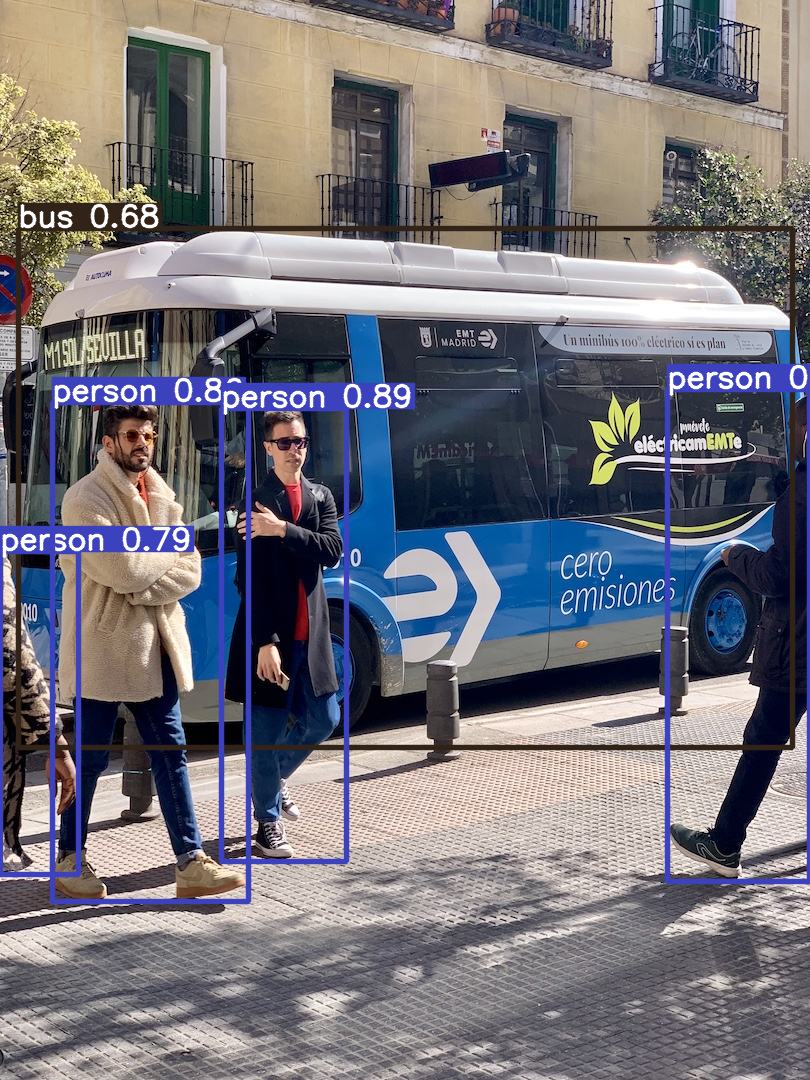

In [16]:
boxes, image, input_shape = detect(compiled_model, 'data/images/bus.jpg')
image_with_boxes = draw_boxes(boxes[0], input_shape, image, NAMES, COLORS)
# visualize results
Image.fromarray(image_with_boxes)

## Model Quantization with NNCF

### Download dataset

YOLOv5 is pre-trained on the COCO dataset, so in order to evaluate the model accuracy we need to download it. According to the instructions provided in the YOLOv7 repo, we also need to download annotations in the format used by the model author for use with the original model evaluation scripts.

In [17]:
coco_cache = "../coco/val2017.cache"
coco128_cache = "../coco128/labels/train2017.cache"
if os.path.exists(coco_cache):
    os.remove(coco_cache)
    
if os.path.exists(coco128_cache):
    os.remove(coco128_cache)

### Create YOLOv5 DataLoader class

In [19]:
from enum import Enum

class COCO_DATASET(Enum):
    COCO_128 = 'data/coco128.yaml'
    COCO = 'data/coco.yaml'

# Change here to test on coco val or coco128 train
DATA_CONFIG = COCO_DATASET.COCO_128.value
print(DATA_CONFIG)

data/coco128.yaml


In [20]:
# Dataloader
if DATA_CONFIG == COCO_DATASET.COCO.value:
    TASK = 'val'
elif DATA_CONFIG == COCO_DATASET.COCO_128.value:
    TASK = 'train'

data_yaml = check_yaml(DATA_CONFIG)
data = check_dataset(data_yaml)
print(data)

dataloader = create_dataloader(
    data[TASK], imgsz=640, batch_size=1, stride=32, pad=0.5, single_cls=False,
    rect=False, workers=4
)[0]

{'path': PosixPath('/home/ease/repos/my_openvino_notebooks/notebooks/yolov5v7/coco128'), 'train': '/home/ease/repos/my_openvino_notebooks/notebooks/yolov5v7/coco128/images/train2017', 'val': '/home/ease/repos/my_openvino_notebooks/notebooks/yolov5v7/coco128/images/train2017', 'test': None, 'names': {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 

Scanning /home/ease/repos/my_openvino_notebooks/notebooks/yolov5v7/coco128/labels/train2017... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 00:00
New cache created: /home/ease/repos/my_openvino_notebooks/notebooks/yolov5v7/coco128/labels/train2017.cache


### Define validation function

We will reuse validation metrics provided in the YOLOv7 repo with a modification for our case (removing extra steps). The original model evaluation procedure can be found in this [file](https://github.com/WongKinYiu/yolov7/blob/main/test.py)

In [21]:
def test(data,
         model: Model,
         dataloader: torch.utils.data.DataLoader,
         conf_thres: float = 0.001,
         iou_thres: float = 0.65,  # for NMS
         single_cls: bool = False,
         names: List[str] = None,
         num_samples: int = None,
         torch_device = "cpu",
        ):
    """
    YOLOv5 accuracy evaluation. Processes validation dataset and compites metrics.
    
    Parameters:
        model (Model): OpenVINO compiled model.
        dataloader (torch.utils.DataLoader): validation dataset.
        conf_thres (float, *optional*, 0.001): minimal confidence threshold for keeping detections
        iou_thres (float, *optional*, 0.65): IOU threshold for NMS
        single_cls (bool, *optional*, False): class agnostic evaluation
        num_samples (int, *optional*, None): number samples for testing
    Returns:
        mp (float): mean precision
        mr (float): mean recall
        map50 (float): mean average precision at 0.5 IOU threshold
        map (float): mean average precision at 0.5:0.95 IOU thresholds
        maps (Dict(int, float): average precision per class
        seen (int): number of evaluated images
        labels (int): number of labels
    """

    model_output = model.output(0)
    check_dataset(data)  # check
    nc = 1 if single_cls else int(data['nc'])  # number of classes
    iouv = torch.linspace(0.5, 0.95, 10)  # iou vector for mAP@0.5:0.95
    niou = iouv.numel()
    
    seen = 0
    p, r, mp, mr, map50, map = 0., 0., 0., 0., 0., 0.
    stats, ap, ap_class = [], [], []
    for sample_id, (img, targets, paths, shapes) in enumerate(tqdm(dataloader)):
        if num_samples is not None and sample_id == num_samples:
            break
        img = prepare_input_tensor(img.numpy())
        targets = targets
        height, width = img.shape[2:]

        with torch.no_grad():
            # Run model
            out = torch.from_numpy(model(img)[model_output])  # inference output            
            # Run NMS
            targets[:, 2:] *= torch.Tensor([width, height, width, height])  # to pixels

            out = non_max_suppression(out, conf_thres=conf_thres, iou_thres=iou_thres, labels=None, multi_label=True)
        
        # Statistics per image
        for si, pred in enumerate(out):
            labels = targets[targets[:, 0] == si, 1:]
            # nl = len(labels)
            nl, npr = labels.shape[0], pred.shape[0]  # number of labels, predictions
            # tcls = labels[:, 0].tolist() if nl else []  # target class
            _, shape = Path(paths[si]), shapes[si][0]
            correct = torch.zeros(npr, niou, dtype=torch.bool, device=torch_device)  # init
            seen += 1

            if npr == 0:
                if nl:
                    # stats.append((torch.zeros(0, niou, dtype=torch.bool), torch.Tensor(), torch.Tensor(), tcls))
                    stats.append((correct, *torch.zeros((2, 0), device=torch_device), labels[:, 0]))
                continue

            # Predictions
            if single_cls:
                pred[:, 5] = 0
            predn = pred.clone()
            scale_boxes(img[si].shape[1:], predn[:, :4], shape, shapes[si][1])  # native-space pred

            # Evaluate
            if nl:
                tbox = xywh2xyxy(labels[:, 1:5])  # target boxes
                scale_boxes(img[si].shape[1:], tbox, shape, shapes[si][1])  # native-space labels
                labelsn = torch.cat((labels[:, 0:1], tbox), 1)  # native-space labels
                correct = process_batch(predn, labelsn, iouv)
                
            stats.append((correct.cpu(), pred[:, 4].cpu(), pred[:, 5].cpu(), labels[:,0]))
            
    # Compute statistics
    class_names = {idx:name for idx,name in enumerate(names)}
    stats = [np.concatenate(x, 0) for x in zip(*stats)]  # to numpy
    if len(stats) and stats[0].any():
        tp, fp, p, r, f1, ap, ap_class = ap_per_class(*stats, plot=True, names=class_names)
        ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
        mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()
        nt = np.bincount(stats[3].astype(np.int64), minlength=nc)  # number of targets per class
    else:
        nt = torch.zeros(1)
    maps = np.zeros(nc) + map
    for i, c in enumerate(ap_class):
        maps[c] = ap[i]
    return mp, mr, map50, map, maps, seen, nt.sum()

Validation function reports following list of accuracy metrics:

* `Precision` is the degree of exactness of the model in identifying only relevant objects. 
* `Recall` measures the ability of the model to detect all ground truths objects.
* `mAP@t` - mean average precision, represented as area under the Precision-Recall curve agregated over all classes in dataset,  where `t` is Intersection Over Union (IOU) threshold, degree of overlaping between ground truth and predicted objects.
            So, `mAP@.5` means that mean average precision calculated at 0.5 IOU threshold, `mAP@.5:.95` - calculated on range IOU threshlods from 0.5 to 0.95 with step 0.05.

In [22]:
# read converted model FP32
model_fp32 = core.read_model('model/yolov5m_fp32.xml')
# load model on CPU device
compiled_model = core.compile_model(model_fp32, 'CPU')

In [22]:
mp, mr, map50, map, maps, num_images, labels = test(data=data, model=compiled_model, dataloader=dataloader, names=NAMES)
# Print results
s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
print(s)
pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
print(pf % ('all', num_images, labels, mp, mr, map50, map))

100%|██████████| 128/128 [00:21<00:00,  5.95it/s]


               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all         128         929       0.726       0.687       0.769       0.554


In [23]:
# read converted model FP16
model_fp16 = core.read_model('model/yolov5m_fp16.xml')
# load model on CPU device
compiled_model = core.compile_model(model_fp16, 'CPU')

In [24]:
mp, mr, map50, map, maps, num_images, labels = test(data=data, model=compiled_model, dataloader=dataloader, names=NAMES)
# Print results
s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
print(s)
pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
print(pf % ('all', num_images, labels, mp, mr, map50, map))

100%|██████████| 128/128 [00:20<00:00,  6.14it/s]


               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all         128         929       0.726       0.686       0.769       0.554


## Optimize model using NNCF Post-training Quantization API

[NNCF](https://github.com/openvinotoolkit/nncf) provides a suite of advanced algorithms for Neural Networks inference optimization in OpenVINO with minimal accuracy drop.
We will use 8-bit quantization in post-training mode (without the fine-tuning pipeline) to optimize YOLOv7.

> **Note**: NNCF Post-training Quantization is available as a preview feature in OpenVINO 2022.3 release.
Fully functional support will be provided in the next releases.

The optimization process contains the following steps:

1. Create Dataset for quantization
2. Run `nncf.quantize` for getting optimized model
3. Serialize OpenVINO IR model using `openvino.runtime.serialize` function

Reuse validation dataloader in accuracy testing for quantization. 
For that, it should be wrapped into the `nncf.Dataset` object and define transformation function for getting only input tensors.

In [30]:
import nncf  # noqa: F811


def transform_fn(data_item):
    """
    Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
    Parameters:
       data_item: Tuple with data item produced by DataLoader during iteration
    Returns:
        input_tensor: Input data for quantization
    """
    img = data_item[0].numpy()
    input_tensor = prepare_input_tensor(img) 
    return input_tensor


quantization_dataset = nncf.Dataset(dataloader, transform_fn)

/home/ease/miniconda3/envs/openvino/lib/python3.8/site-packages/openvino/offline_transformations/__init__.py:10: FutureWarning: The module is private and following namespace `offline_transformations` will be removed in the future, use `openvino.runtime.passes` instead!
  warnings.warn(


`nncf.quantize` function provides interface for model quantization. It requires instance of OpenVINO Model and quantization dataset. 
Optionally, some additional parameters for configuration quantization process (number of samples for quantization, preset, ignored scope etc.) can be provided.
YOLOv7 model contains non-ReLU activation functions, which require asymmetric quantization of activations. To achive better result we will use `mixed` quantization preset.
It provides symmetric quantization of weights and asymmetric quantization of activations.

In [31]:
quantized_model = nncf.quantize(model_fp16, quantization_dataset, preset=nncf.QuantizationPreset.MIXED)

serialize(quantized_model, 'model/yolov5m_int8.xml')

INFO:openvino.tools.pot.pipeline.pipeline:Inference Engine version:                2022.3.0-8831-4f0b846d1a5
INFO:openvino.tools.pot.pipeline.pipeline:Model Optimizer version:                 2022.3.0-8831-4f0b846d1a5
INFO:openvino.tools.pot.pipeline.pipeline:Post-Training Optimization Tool version: 2022.3.0-8831-4f0b846d1a5
INFO:openvino.tools.pot.statistics.collector:Start computing statistics for algorithms : DefaultQuantization
INFO:openvino.tools.pot.statistics.collector:Computing statistics finished
INFO:openvino.tools.pot.pipeline.pipeline:Start algorithm: DefaultQuantization
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Start computing statistics for algorithm : ActivationChannelAlignment
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Computing statistics finished
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Start computing statistics for algorithms : MinMaxQuantization,FastBiasCorrection
INFO:openvino.tools.pot.algori

## Validate Quantized model inference

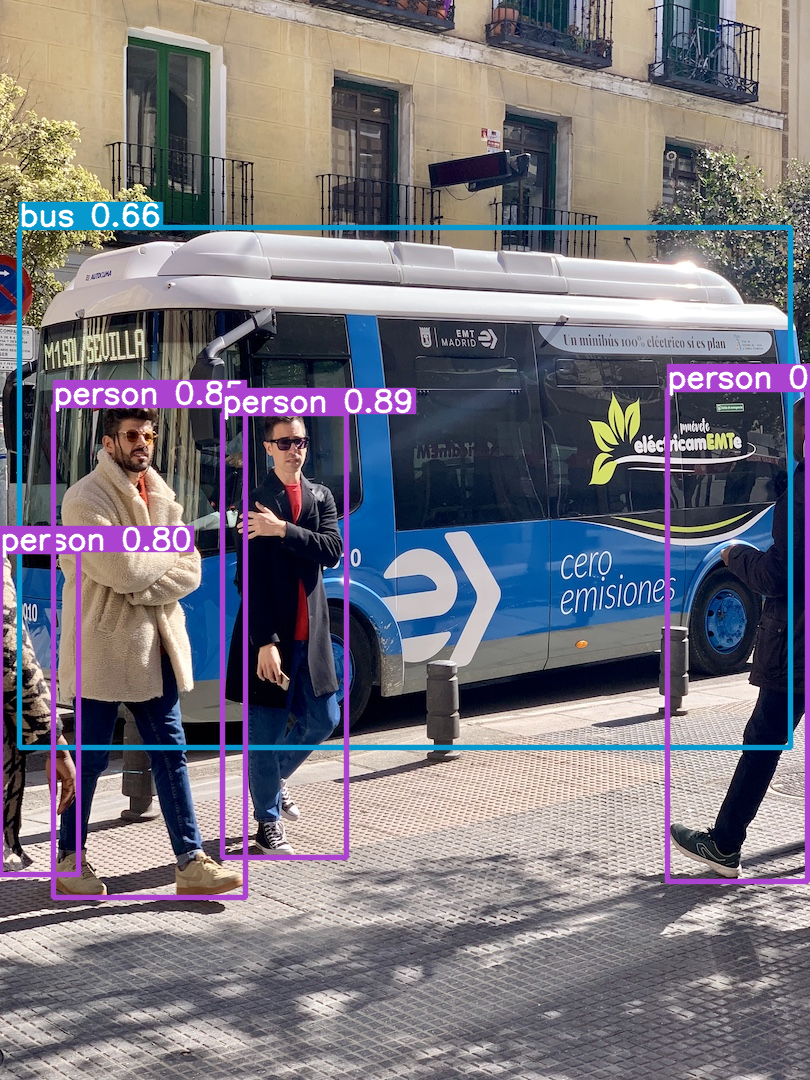

In [32]:
int8_compiled_model = core.compile_model(quantized_model, 'CPU')
boxes, image, input_shape = detect(int8_compiled_model, 'data/images/bus.jpg')
image_with_boxes = draw_boxes(boxes[0], input_shape, image, NAMES, COLORS)
Image.fromarray(image_with_boxes)

## Validate quantized model accuracy

In [33]:
int8_result = test(data=data, model=int8_compiled_model, dataloader=dataloader, names=NAMES)

100%|██████████| 128/128 [00:07<00:00, 17.99it/s]


In [34]:
mp, mr, map50, map, maps, num_images, labels = int8_result
# Print results
s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
print(s)
pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
print(pf % ('all', num_images, labels, mp, mr, map50, map))

               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all         128         929       0.743       0.677       0.767       0.545


## Benchmark

In [8]:
# Inference FP32 model using CPU (OpenVINO IR)
!benchmark_app -m {MODEL_DIR}/{MODEL_NAME}_fp32.xml -d CPU -api async

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2022.3.0-8831-4f0b846d1a5
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2022.3.0-8831-4f0b846d1a5
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 105.29 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [1,25200,85]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[Step 6/11] Configuring input of the model
[ INFO ] Model inputs:

In [9]:
# Inference FP16 model using CPU (OpenVINO IR)
!benchmark_app -m {MODEL_DIR}/{MODEL_NAME}_fp16.xml -d CPU -api async

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2022.3.0-8831-4f0b846d1a5
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2022.3.0-8831-4f0b846d1a5
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 47.31 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [1,25200,85]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[Step 6/11] Configuring input of the model
[ INFO ] Model inputs:


In [30]:
# Inference INT8 model using CPU (OpenVINO IR)
!benchmark_app -m {MODEL_DIR}/{MODEL_NAME}_int8.xml -d CPU -api async

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2022.3.0-8831-4f0b846d1a5
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2022.3.0-8831-4f0b846d1a5
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 44.69 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [1,25200,85]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[Step 6/11] Configuring input of the model
[ INFO ] Model inputs:


In [10]:
# Inference FP32 model using GPU (OpenVINO IR)
!benchmark_app -m {MODEL_DIR}/{MODEL_NAME}_fp32.xml -d GPU -api async

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2022.3.0-8831-4f0b846d1a5
[ INFO ] 
[ INFO ] Device info:
[ INFO ] GPU
[ INFO ] Build ................................. 2022.3.0-8831-4f0b846d1a5
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(GPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 58.43 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [1,25200,85]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[Step 6/11] Configuring input of the model
[ INFO ] Model inputs:


In [11]:
# Inference FP32 model using GPU (OpenVINO IR)
!benchmark_app -m {MODEL_DIR}/{MODEL_NAME}_fp16.xml -d GPU -api async

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2022.3.0-8831-4f0b846d1a5
[ INFO ] 
[ INFO ] Device info:
[ INFO ] GPU
[ INFO ] Build ................................. 2022.3.0-8831-4f0b846d1a5
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(GPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 39.51 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [1,25200,85]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[Step 6/11] Configuring input of the model
[ INFO ] Model inputs:


In [12]:
# Inference INT8 model using GPU (OpenVINO IR)
!benchmark_app -m {MODEL_DIR}/{MODEL_NAME}_int8.xml -d GPU -api async

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2022.3.0-8831-4f0b846d1a5
[ INFO ] 
[ INFO ] Device info:
[ INFO ] GPU
[ INFO ] Build ................................. 2022.3.0-8831-4f0b846d1a5
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(GPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 43.86 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [1,25200,85]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[Step 6/11] Configuring input of the model
[ INFO ] Model inputs:
